## Facies classification - Sequential Feature Selection

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas in this notebook,</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl,</span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

The [mlxtend](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) library used for the sequential feature selection is by [Sebastian Raschka](https://sebastianraschka.com/projects.html).

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, make_scorer

In [29]:
filename = 'train_engineered_features.csv'
train_data = pd.read_csv(filename)
train_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_d1,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,-0.000250,...,0.362744,0.508851,0.759942,0.603343,0.719862,0.824668,0.882453,0.914078,0.929500,0.804835
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644,0.322450,...,0.349133,0.264859,0.650069,0.480311,0.288003,0.176777,0.120571,0.081636,0.055219,0.190367
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-4.054936,...,0.096319,0.316176,-1.000000,-1.000000,-0.585463,-0.374228,0.006510,0.172521,0.535185,0.057670
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,-0.094888,...,0.126938,0.335702,1.000000,0.333333,0.563576,0.744050,0.839252,0.886120,0.900920,0.716265
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000,0.009984,...,0.155859,0.366067,1.000000,0.812079,0.812063,0.865431,0.904105,0.922402,0.930043,0.856678
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000,0.103486,...,0.459545,0.517911,1.000000,1.000000,0.952660,0.957511,0.966665,0.967000,0.962272,0.946690
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,3.835455,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
train_data['Well Name'] = train_data['Well Name'].astype('category')
train_data['Formation'] = train_data['Formation'].astype('category')
train_data['Well Name'].unique()

[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]

In [31]:
y = train_data['Facies'].values
print y[25:40]
print np.shape(y)

[3 3 2 2 2 2 2 2 3 3 3 3 3 3 3]
(4149,)


In [32]:
X = train_data.drop(['Formation', 'Well Name','Facies'], axis=1)
print np.shape(X)
X.describe(percentiles=[.05, .25, .50, .75, .95])

(4149, 378)


,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_d1,GR_d2,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,...,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000
mean,2906.867438,64.933985,0.659566,4.402484,13.201066,3.725014,1.518438,0.521852,-0.000250,0.001948,...,0.362744,0.508851,0.759942,0.603343,0.719862,0.824668,0.882453,0.914078,0.929500,0.804835
std,133.300164,30.302530,0.252703,5.274947,7.132846,0.790917,0.499720,0.286644,0.322450,0.204689,...,0.349133,0.264859,0.650069,0.480311,0.288003,0.176777,0.120571,0.081636,0.055219,0.190367
min,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000,-4.054936,-2.996563,...,0.096319,0.316176,-1.000000,-1.000000,-0.585463,-0.374228,0.006510,0.172521,0.535185,0.057670
5%,2644.200000,22.313200,0.255012,-4.000000,4.927800,2.600000,1.000000,0.070000,-0.445132,-0.246826,...,0.105974,0.321458,-1.000000,-0.333333,0.132645,0.480292,0.643018,0.782681,0.841858,0.398231
25%,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000,-0.094888,-0.054821,...,0.126938,0.335702,1.000000,0.333333,0.563576,0.744050,0.839252,0.886120,0.900920,0.716265
50%,2932.500000,64.990000,0.639000,4.300000,12.020000,3.725014,2.000000,0.528000,0.009984,0.005999,...,0.155859,0.366067,1.000000,0.812079,0.812063,0.865431,0.904105,0.922402,0.930043,0.856678
75%,3007.000000,79.438000,0.822000,7.500000,16.050000,4.000000,2.000000,0.769000,0.103486,0.065753,...,0.459545,0.517911,1.000000,1.000000,0.952660,0.957511,0.966665,0.967000,0.962272,0.946690
95%,3094.000000,105.841000,1.079600,12.800000,25.380000,5.200000,2.000000,0.964000,0.374634,0.232004,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000,3.835455,1.835877,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
stdscaler = preprocessing.StandardScaler().fit(X)
X = stdscaler.transform(X)

### Make performance scorers 

In [34]:
Fscorer = make_scorer(f1_score, average = 'micro')

### Sequential Feature Selection with mlextend

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In [35]:
from sklearn.ensemble import RandomForestClassifier

### The next cell will take many hours to run, skip it

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
clf = RandomForestClassifier(random_state=49)

sfs = SFS(clf, 
          k_features=100, 
          forward=True, 
          floating=False, 
          scoring=Fscorer,
          cv = 8,
          n_jobs = -1)

sfs = sfs.fit(X_train, y_train)


Features: 100/100

In [11]:
np.save('sfs_RF_metric_dict.npy', sfs.get_metric_dict()) 

### Restart from here

In [36]:
# load previously saved dictionary
read_dictionary = np.load('sfs_RF_metric_dict.npy').item()

In [37]:
# plot results
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

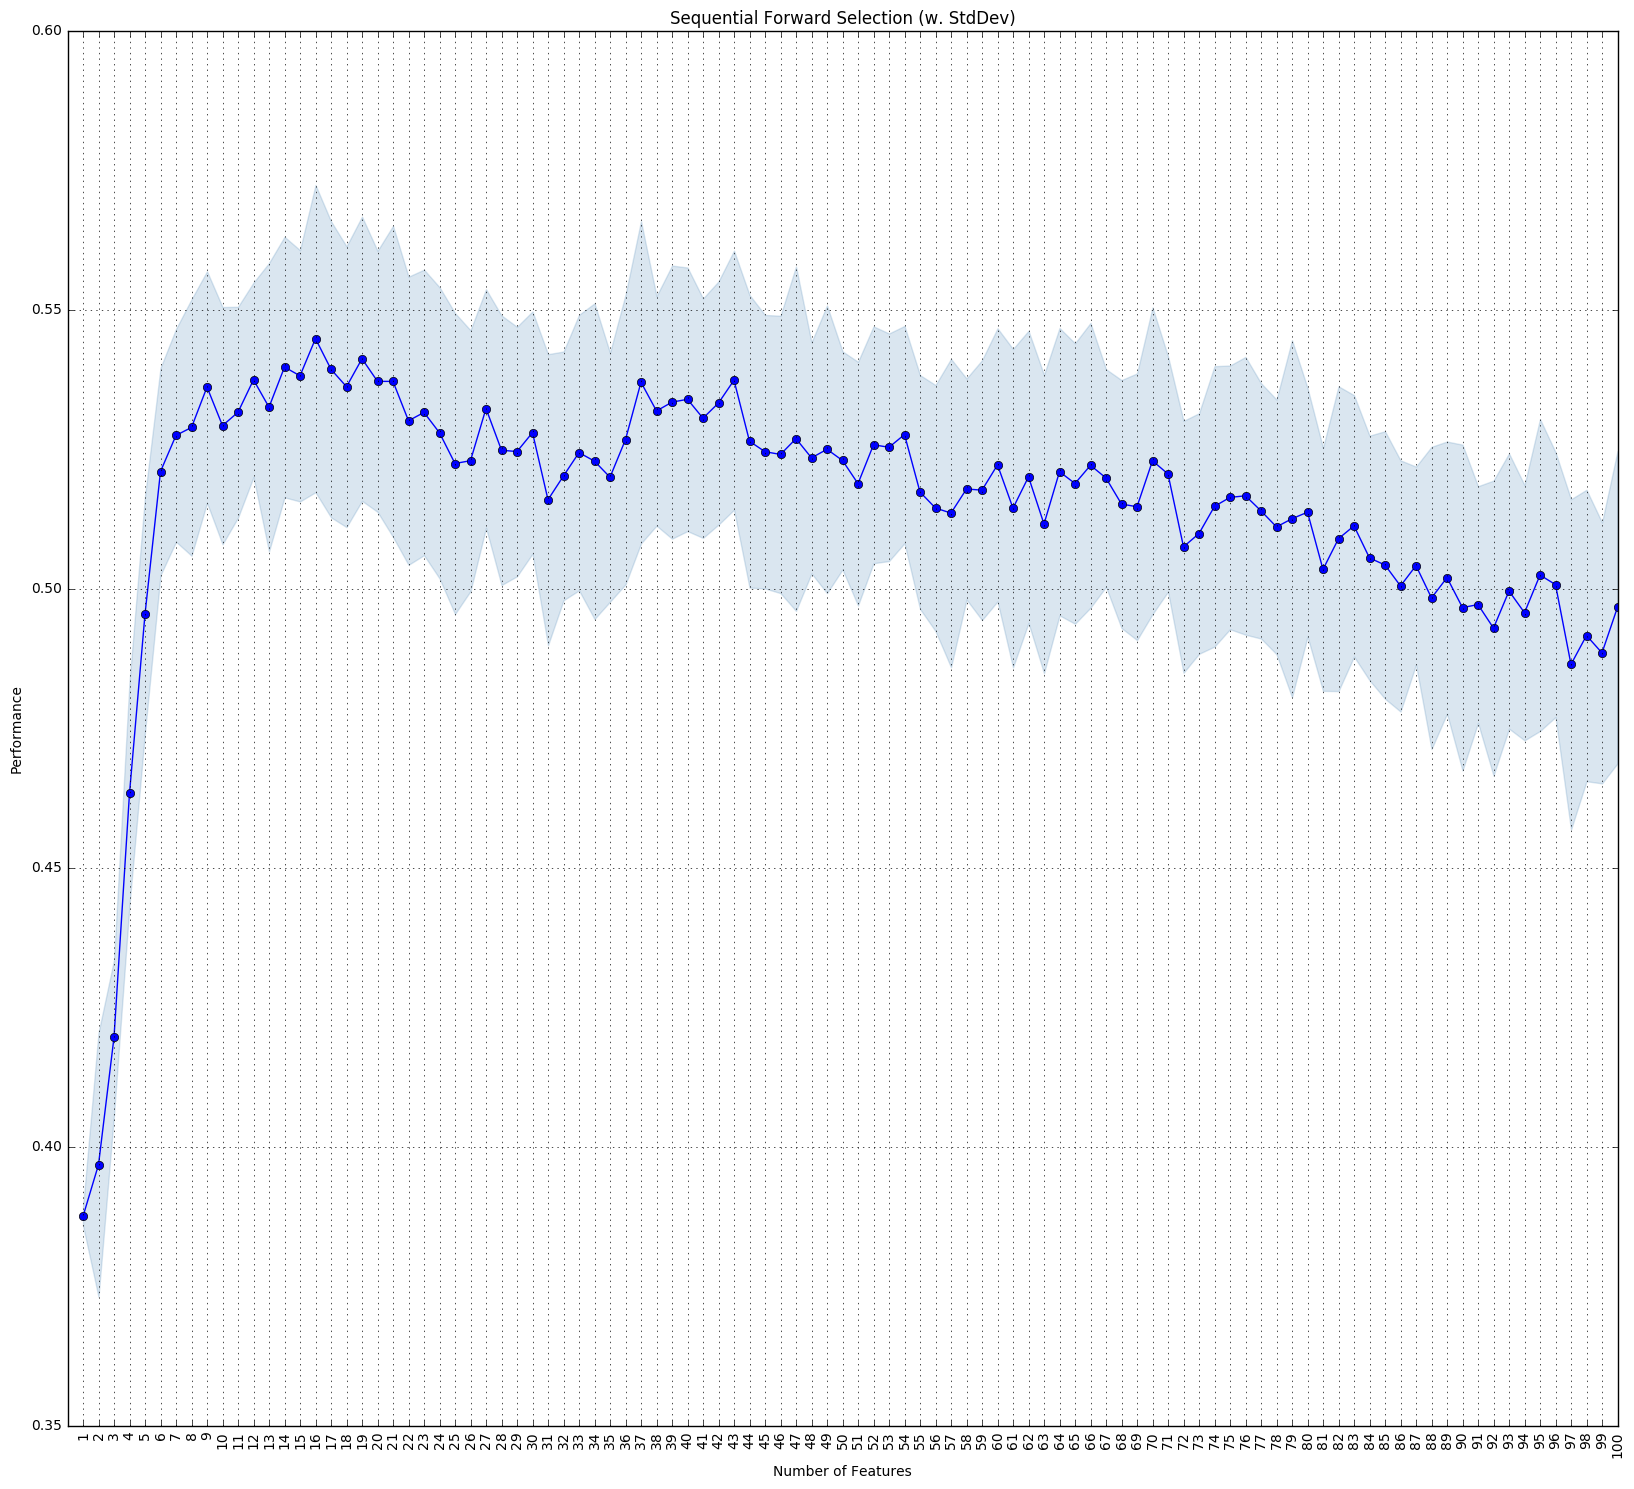

In [39]:
# run this twice
fig = plt.figure()                                                               
ax = plot_sfs(read_dictionary, kind='std_err')
fig_size = plt.rcParams["figure.figsize"] 
fig_size[0] = 20
fig_size[1] = 18

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.xticks( rotation='vertical')
locs, labels = plt.xticks()
plt.xticks( locs, labels)
plt.show()

##### The curve stabiizes at about 6 features, reaches a max at 15, then more or less flattens up to about 70 features wher it begins to tail off. We will save the top 45 and 75. 

In [40]:
# save results to dataframe
selected_summary = pd.DataFrame.from_dict(read_dictionary).T
selected_summary['index'] = selected_summary.index
selected_summary.sort_values(by='avg_score', ascending=0)

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err,index
16,0.54485,0.0634797,"[0.613026819923, 0.604606525912, 0.51439539347...","(97, 34, 163, 4, 6, 7, 8, 42, 12, 16, 18, 193,...",0.0728323,0.027528,16
19,0.541246,0.0587401,"[0.582375478927, 0.593090211132, 0.53358925144...","(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.0673943,0.0254727,19
14,0.53975,0.0538387,"[0.61877394636, 0.552783109405, 0.529750479846...","(97, 34, 163, 4, 6, 7, 42, 12, 16, 18, 84, 119...",0.0617709,0.0233472,14
17,0.539349,0.0611887,"[0.557471264368, 0.581573896353, 0.49520153550...","(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.0702037,0.0265345,17
15,0.538184,0.0519295,"[0.590038314176, 0.537428023033, 0.44529750479...","(97, 34, 163, 4, 6, 7, 8, 42, 12, 16, 18, 84, ...",0.0595803,0.0225193,15
12,0.53747,0.0401907,"[0.565134099617, 0.535508637236, 0.55662188099...","(97, 34, 163, 4, 6, 7, 42, 12, 16, 18, 84, 155)",0.046112,0.0174287,12
43,0.537399,0.0535474,"[0.590038314176, 0.537428023033, 0.56429942418...","(257, 3, 4, 6, 7, 8, 10, 12, 16, 273, 146, 19,...",0.0614366,0.0232209,43
20,0.537191,0.0539331,"[0.565134099617, 0.535508637236, 0.55086372360...","(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.0618792,0.0233881,20
21,0.537181,0.0642947,"[0.57662835249, 0.564299424184, 0.508637236084...","(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.0737674,0.0278814,21
37,0.537034,0.0666117,"[0.639846743295, 0.552783109405, 0.53358925144...","(257, 3, 4, 6, 7, 8, 10, 12, 16, 146, 155, 284...",0.0764257,0.0288862,37


In [41]:
# save dataframe
selected_summary.to_csv('SFS_RF_selected_features_summary.csv', sep=',', header=True, index = False)

In [44]:
# re load saved dataframe and sort by score
filename = 'SFS_RF_selected_features_summary.csv'
selected_summary = pd.read_csv(filename)
selected_summary = selected_summary.set_index(['index'])
selected_summary.sort_values(by='avg_score', ascending=0).head()

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
index,,,,,,
16,0.544850,0.063480,[ 0.61302682 0.60460653 0.51439539 0.598848...,"(97, 34, 163, 4, 6, 7, 8, 42, 12, 16, 18, 193,...",0.072832,0.027528
19,0.541246,0.058740,[ 0.58237548 0.59309021 0.53358925 0.608445...,"(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.067394,0.025473
14,0.539750,0.053839,[ 0.61877395 0.55278311 0.52975048 0.598848...,"(97, 34, 163, 4, 6, 7, 42, 12, 16, 18, 84, 119...",0.061771,0.023347
17,0.539349,0.061189,[ 0.55747126 0.5815739 0.49520154 0.641074...,"(193, 4, 6, 7, 8, 203, 12, 16, 18, 84, 90, 155...",0.070204,0.026535
15,0.538184,0.051929,[ 0.59003831 0.53742802 0.4452975 0.625719...,"(97, 34, 163, 4, 6, 7, 8, 42, 12, 16, 18, 84, ...",0.059580,0.022519


In [45]:
# feature selection with highest score
selected_summary.iloc[44]['feature_idx']

'(257, 3, 4, 6, 7, 8, 10, 12, 16, 273, 146, 19, 26, 27, 284, 285, 30, 34, 163, 1, 42, 179, 155, 181, 184, 58, 315, 190, 320, 193, 194, 203, 290, 80, 210, 35, 84, 90, 97, 18, 241, 372, 119, 120, 126)'

In [46]:
slct = np.array([257, 3, 4, 6, 7, 8, 10, 12, 16, 273, 146, 19, 26, 27, 284, 285, 30, 34, 163, 1, 42, 179, 155, 181, 184, 58, 315, 190, 320, 193, 194, 203, 290, 80, 210, 35, 84, 90, 97, 18, 241, 372, 119, 120, 126])
slct

array([257,   3,   4,   6,   7,   8,  10,  12,  16, 273, 146,  19,  26,
        27, 284, 285,  30,  34, 163,   1,  42, 179, 155, 181, 184,  58,
       315, 190, 320, 193, 194, 203, 290,  80, 210,  35,  84,  90,  97,
        18, 241, 372, 119, 120, 126])

In [52]:
# isolate and save selected features
filename = 'train_engineered_features.csv'
train_data = pd.read_csv(filename)
trainX = train_data.drop(['Formation', 'Well Name','Facies'], axis=1)
trainXs = trainX.iloc[:, slct]
trainXs = pd.concat([train_data[['Depth', 'Well Name', 'Formation', 'Facies']], trainXs], axis = 1)
print np.shape(trainXs), list(trainXs)
trainXs.to_csv('train_SFS_top45_engfeat.csv', sep=',',  index=False)

(4149, 49) ['Depth', 'Well Name', 'Formation', 'Facies', 'PE_GLCM_correlation_wsize=ave', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS', 'GR_d1', 'ILD_log10_d1', 'DeltaPHI_d1', 'PE_d1', 'GR_GLCM_energy_asym_wsize=ave', 'GR_GLCM_energy_wsize=3', 'GR_mean_wsize=5', 'GR_std_wsize=3', 'GR_std_wsize=5', 'ILD_log10_GLCM_dissimilarity_asym_wsize=9', 'ILD_log10_GLCM_dissimilarity_asym_wsize=17', 'GR_std_wsize=33', 'GR_skew_wsize=3', 'ILD_log10_GLCM_dissimilarity_wsize=5', 'GR', 'ILD_log10_mean_wsize=3', 'ILD_log10_GLCM_correlation_wsize=5', 'GR_GLCM_correlation_wsize=5', 'ILD_log10_GLCM_correlation_wsize=17', 'ILD_log10_GLCM_correlation_wsize=129', 'ILD_log10_skew_wsize=3', 'DeltaPHI_GLCM_energy_asym_wsize=5', 'DeltaPHI_GLCM_dissimilarity_wsize=33', 'DeltaPHI_GLCM_energy_asym_wsize=129', 'DeltaPHI_GLCM_dissimilarity_wsize=ave', 'DeltaPHI_GLCM_energy_wsize=3', 'DeltaPHI_GLCM_correlation_wsize=5', 'ILD_log10_GLCM_energy_asym_wsize=3', 'DeltaPHI_std_wsize=129', 'PHIND_GLCM_dissimilarity_wsize=3', 'GR_ske

In [53]:
# isolate and save selected features
filename = 'test_engineered_features.csv'
test_data = pd.read_csv(filename)
testX = test_data.drop(['Formation', 'Well Name'], axis=1)
testXs = testX.iloc[:, slct]
testXs = pd.concat([test_data[['Depth', 'Well Name', 'Formation']], testXs], axis = 1)
print np.shape(testXs), list(testXs)
testXs.to_csv('test_SFS_top45_engfeat.csv', sep=',',  index=False)

(830, 48) ['Depth', 'Well Name', 'Formation', 'PE_GLCM_correlation_wsize=ave', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS', 'GR_d1', 'ILD_log10_d1', 'DeltaPHI_d1', 'PE_d1', 'GR_GLCM_energy_asym_wsize=ave', 'GR_GLCM_energy_wsize=3', 'GR_mean_wsize=5', 'GR_std_wsize=3', 'GR_std_wsize=5', 'ILD_log10_GLCM_dissimilarity_asym_wsize=9', 'ILD_log10_GLCM_dissimilarity_asym_wsize=17', 'GR_std_wsize=33', 'GR_skew_wsize=3', 'ILD_log10_GLCM_dissimilarity_wsize=5', 'GR', 'ILD_log10_mean_wsize=3', 'ILD_log10_GLCM_correlation_wsize=5', 'GR_GLCM_correlation_wsize=5', 'ILD_log10_GLCM_correlation_wsize=17', 'ILD_log10_GLCM_correlation_wsize=129', 'ILD_log10_skew_wsize=3', 'DeltaPHI_GLCM_energy_asym_wsize=5', 'DeltaPHI_GLCM_dissimilarity_wsize=33', 'DeltaPHI_GLCM_energy_asym_wsize=129', 'DeltaPHI_GLCM_dissimilarity_wsize=ave', 'DeltaPHI_GLCM_energy_wsize=3', 'DeltaPHI_GLCM_correlation_wsize=5', 'ILD_log10_GLCM_energy_asym_wsize=3', 'DeltaPHI_std_wsize=129', 'PHIND_GLCM_dissimilarity_wsize=3', 'GR_skew_wsize=5',

In [54]:
# feature selection with highest score
selected_summary.iloc[74]['feature_idx']

'(257, 3, 4, 5, 6, 7, 8, 265, 10, 12, 13, 16, 273, 18, 19, 26, 27, 284, 285, 30, 34, 35, 1, 42, 304, 309, 313, 58, 315, 319, 320, 75, 80, 338, 84, 341, 89, 90, 92, 97, 101, 102, 110, 372, 119, 120, 122, 124, 126, 127, 138, 139, 146, 155, 163, 165, 167, 171, 177, 179, 180, 181, 184, 190, 193, 194, 198, 203, 290, 210, 211, 225, 241, 249, 253)'

In [55]:
slct = np.array([257, 3, 4, 5, 6, 7, 8, 265, 10, 12, 13, 16, 273, 18, 19, 26, 27, 284, 285, 30, 34, 35, 1, 42, 304, 309, 313, 58, 315, 319, 320, 75, 80, 338, 84, 341, 89, 90, 92, 97, 101, 102, 110, 372, 119, 120, 122, 124, 126, 127, 138, 139, 146, 155, 163, 165, 167, 171, 177, 179, 180, 181, 184, 190, 193, 194, 198, 203, 290, 210, 211, 225, 241, 249, 253])
slct

array([257,   3,   4,   5,   6,   7,   8, 265,  10,  12,  13,  16, 273,
        18,  19,  26,  27, 284, 285,  30,  34,  35,   1,  42, 304, 309,
       313,  58, 315, 319, 320,  75,  80, 338,  84, 341,  89,  90,  92,
        97, 101, 102, 110, 372, 119, 120, 122, 124, 126, 127, 138, 139,
       146, 155, 163, 165, 167, 171, 177, 179, 180, 181, 184, 190, 193,
       194, 198, 203, 290, 210, 211, 225, 241, 249, 253])

In [56]:
# isolate and save selected features
filename = 'train_engineered_features.csv'
train_data = pd.read_csv(filename)
trainX = train_data.drop(['Formation', 'Well Name','Facies'], axis=1)
trainXs = trainX.iloc[:, slct]
trainXs = pd.concat([train_data[['Depth', 'Well Name', 'Formation', 'Facies']], trainXs], axis = 1)
print np.shape(trainXs), list(trainXs)
trainXs.to_csv('train_SFS_top75_engfeat.csv', sep=',',  index=False)

(4149, 79) ['Depth', 'Well Name', 'Formation', 'Facies', 'PE_GLCM_correlation_wsize=ave', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'GR_d1', 'GR_GLCM_dissimilarity_asym_wsize=ave', 'ILD_log10_d1', 'DeltaPHI_d1', 'DeltaPHI_d2', 'PE_d1', 'GR_GLCM_energy_asym_wsize=ave', 'GR_mean_wsize=3', 'GR_mean_wsize=5', 'GR_std_wsize=3', 'GR_std_wsize=5', 'ILD_log10_GLCM_dissimilarity_asym_wsize=9', 'ILD_log10_GLCM_dissimilarity_asym_wsize=17', 'GR_std_wsize=33', 'GR_skew_wsize=3', 'GR_skew_wsize=5', 'GR', 'ILD_log10_mean_wsize=3', 'ILD_log10_GLCM_correlation_asym_wsize=129', 'DeltaPHI_GLCM_dissimilarity_asym_wsize=17', 'DeltaPHI_GLCM_dissimilarity_asym_wsize=ave', 'ILD_log10_skew_wsize=3', 'DeltaPHI_GLCM_energy_asym_wsize=5', 'DeltaPHI_GLCM_energy_asym_wsize=65', 'DeltaPHI_GLCM_energy_asym_wsize=129', 'DeltaPHI_std_wsize=5', 'DeltaPHI_std_wsize=129', 'PHIND_GLCM_energy_asym_wsize=3', 'DeltaPHI_skew_wsize=9', 'PHIND_GLCM_energy_asym_wsize=17', 'DeltaPHI_skew_wsize=ave', 'PHIND_mean_wsize=3', 'PHIN

In [57]:
# isolate and save selected features
filename = 'test_engineered_features.csv'
test_data = pd.read_csv(filename)
testX = test_data.drop(['Formation', 'Well Name'], axis=1)
testXs = testX.iloc[:, slct]
testXs = pd.concat([test_data[['Depth', 'Well Name', 'Formation']], testXs], axis = 1)
print np.shape(testXs), list(testXs)
testXs.to_csv('test_SFS_top75_engfeat.csv', sep=',',  index=False)

(830, 78) ['Depth', 'Well Name', 'Formation', 'PE_GLCM_correlation_wsize=ave', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'GR_d1', 'GR_GLCM_dissimilarity_asym_wsize=ave', 'ILD_log10_d1', 'DeltaPHI_d1', 'DeltaPHI_d2', 'PE_d1', 'GR_GLCM_energy_asym_wsize=ave', 'GR_mean_wsize=3', 'GR_mean_wsize=5', 'GR_std_wsize=3', 'GR_std_wsize=5', 'ILD_log10_GLCM_dissimilarity_asym_wsize=9', 'ILD_log10_GLCM_dissimilarity_asym_wsize=17', 'GR_std_wsize=33', 'GR_skew_wsize=3', 'GR_skew_wsize=5', 'GR', 'ILD_log10_mean_wsize=3', 'ILD_log10_GLCM_correlation_asym_wsize=129', 'DeltaPHI_GLCM_dissimilarity_asym_wsize=17', 'DeltaPHI_GLCM_dissimilarity_asym_wsize=ave', 'ILD_log10_skew_wsize=3', 'DeltaPHI_GLCM_energy_asym_wsize=5', 'DeltaPHI_GLCM_energy_asym_wsize=65', 'DeltaPHI_GLCM_energy_asym_wsize=129', 'DeltaPHI_std_wsize=5', 'DeltaPHI_std_wsize=129', 'PHIND_GLCM_energy_asym_wsize=3', 'DeltaPHI_skew_wsize=9', 'PHIND_GLCM_energy_asym_wsize=17', 'DeltaPHI_skew_wsize=ave', 'PHIND_mean_wsize=3', 'PHIND_mean_wsiz